In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import holidays

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# from xgboost import XGBRegressor, plot_tree
# import xgboost as xgb
# import lightgbm as lgb
from pprint import pprint

# = = = = = =
# own stuff

os.chdir("C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC")
from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [3]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


In [4]:
import os as os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

### Data Split

In [282]:
df_energy_dummy = create_dummy_df(df_energy, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = create_features_df(df_energy, holiday_method='separate', lags=[24, 7*24])

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2016-01-01'
end     = '2023-01-01'
df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > start) & 
                                            (df_energy_dummy['timestamp_CET'] <= end)]
df_energy_fturs_small = df_energy_fturs.loc[(df_energy_fturs['timestamp_CET'] > start) & 
                                            (df_energy_fturs['timestamp_CET'] <= end)]

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =                                       
# time series train test split

# use sklearn TimeSeriesSplit to genrate ...
    # X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy
    # X_train_fturs, X_test_fturs, y_train_fturs, y_test_fturs

X = df_energy_fturs_small.drop(['gesamt', 'timestamp_CET'], axis=1)
y = df_energy_fturs_small['gesamt']

tscv = TimeSeriesSplit(n_splits=2, test_size=200)
for train_index, test_index in tscv.split(X):
    X_train_fturs, X_test_fturs = X.iloc[train_index], X.iloc[test_index]
    y_train_fturs, y_test_fturs = y.iloc[train_index], y.iloc[test_index]

X = df_energy_dummy_small.drop(['gesamt', 'timestamp_CET'], axis=1)
y = df_energy_dummy_small['gesamt']

for train_index, test_index in tscv.split(X):
    X_train_dummy, X_test_dummy = X.iloc[train_index], X.iloc[test_index]
    y_train_dummy, y_test_dummy = y.iloc[train_index], y.iloc[test_index]

# [TODO] cross validation

In [278]:
# start_date = '2021-12-23'
# end_date = '2021-12-28'

# plt.figure(figsize=(20, 5))
# plt.plot(y_train_fturs.loc[(y_train_fturs.index > start_date) & (y_train_fturs.index < end_date)], label='train')
# plt.legend()
# plt.show()

### Model Train & Fcast

In [6]:
# quant_reg_model = QuantileRegressor(quantile=0.05, alpha=0, solver='highs')
# # alpha is ... Regularization constant that multiplies the L1 penalty term.
# # if alpha is too high ... ie 1 or even 0.5 the coeff are all 0 leading to a constant prediction ...
# # at alpha = 0.1 there are still some constant predictions at extreme quantiles

# quant_reg_fit = quant_reg_model.fit(X_train_dummy, y_train_dummy)

# print(quant_reg_fit.get_params())
# print(quant_reg_fit.intercept_)
# print(quant_reg_fit.coef_)

# # lin_reg_model = LinearRegression()
# # lin_reg_fit = lin_reg_model.fit(X_train_dummy, y_train_dummy)

# # get in sample pred of model
# y_pred_in_sample = quant_reg_fit.predict(X_train_dummy)
# # y_pred_in_sample = lin_reg_fit.predict(X_train_dummy)

# # plot
# plt.figure(figsize=(10, 5))
# plt.plot(y_train_dummy, label='train')
# plt.plot(y_train_dummy.index, y_pred_in_sample, label='in sample fit')
# plt.show()

In [283]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train quantile models ... regression and gradient boosting

# - - - - - - - - - -
# quantile regression with dummies

# !!! IMPORTANT !!!
# check best params ... alpha = ??? 

print('- '*15)  
print(f'> start training quantile regression models ...')
all_models_quant_reg = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')
    quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
    all_models_quant_reg[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy, y_train_dummy)

    # print(quantile_regressor.intercept_)
    # df_coef_w_names = pd.DataFrame(quantile_regressor.coef_, index=quantile_regressor.feature_names_in_)
    # print(df_coef_w_names.to_string())

# - - - - - - - - - -
# gradient boosting with features

# !!! IMPORTANT !!! 
# grid search for best params
# for each quantile ???

# common_params = dict(
#     learning_rate=0.3,
#     max_depth=7,
#     min_samples_leaf=5,
#     n_estimators=300, 
#     subsample=0.9
# )
    
# quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 400, 'subsample': 0.9}, 
#                    0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 250, 'subsample': 0.7},
#                    0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.8},
#                    0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7, 'n_estimators': 250, 'subsample': 0.7},
#                    0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.7}}

quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7}, 
                   0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6},
                   0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6},
                   0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7},
                   0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6}}

print('- '*15)  
print(f'> start training gradient boosting models ...')
all_models_grad_boost = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')

    params = quantile_params[alpha]
    # pprint(params)

    # Use the QuantileRegressor for faster training on small to medium datasets n < 10_000
    # gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **params)

    # Use the HistGradientBoostingRegressor for faster training on large datasets n > 10_000
    gbr = HistGradientBoostingRegressor(loss='quantile', quantile=alpha, **params)

    all_models_grad_boost[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs, y_train_fturs)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# prediction on test set

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_pred = pd.DataFrame(index=y_test_dummy.index)
df_grad_boost_pred = pd.DataFrame(index=y_test_fturs.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    df_quant_reg_pred[name] = quant_reg_model.predict(X_test_dummy)

# Prediction for Gradient Boosting
for name, grad_boost_model in sorted(all_models_grad_boost.items()):
    df_grad_boost_pred[name] = grad_boost_model.predict(X_test_fturs)

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

- - - - - - - - - - - - - - - 
> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
- - - - - - - - - - - - - - - 
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
- - - - - - - - - - - - - - - 
> start prediction ...


In [284]:
quantile = '0.500'
print(all_models_quant_reg[f"q {quantile}"].intercept_)
df_coef_w_names = pd.DataFrame(all_models_quant_reg[f"q {quantile}"].coef_, index=all_models_quant_reg[f"q {quantile}"].feature_names_in_)
print(df_coef_w_names.to_string())

55414.0
                                     0
month_2                       -540.125
month_3                      -3444.750
month_4                      -6630.375
month_5                      -7910.375
month_6                      -8714.375
month_7                      -8809.250
month_8                      -9798.625
month_9                      -8404.000
month_10                     -5645.250
month_11                     -2793.750
month_12                     -1003.750
weekday_1                     1149.500
weekday_2                     1311.000
weekday_3                     1251.500
weekday_4                      113.375
weekday_5                    -8850.375
weekday_6                   -12133.125
hour_1_summer                -1785.000
hour_2_summer                -2738.125
hour_3_summer                -2632.125
hour_4_summer                -1537.750
hour_5_summer                 1321.875
hour_6_summer                 6842.875
hour_7_summer                11641.500
hour_8_summer    

### Plots

In [280]:
# - - - - - - - - - - 
# simple ensemble average
# df_ensemble_pred = pd.concat((df_quant_reg_pred, df_grad_boost_pred))

# custom weights for each DataFrame
weight_quant_reg = 0.5
weight_grad_boost = 0.5

df_ensemble_pred = (df_quant_reg_pred * weight_quant_reg +
                    df_grad_boost_pred * weight_grad_boost)
df_ensemble_pred = df_ensemble_pred.groupby(df_ensemble_pred.index).mean()

# - - - - - - - - - - 
# special ensemble combination
# df_temp = pd.concat((df_quant_reg_pred, df_grad_boost_pred))
# df_minmax_ens_pred = df_temp.groupby(df_temp.index).agg({'q 0.025': 'min', 
#                                                          'q 0.250': 'min', 
#                                                          'q 0.500': 'mean',
#                                                          'q 0.750': 'max',
#                                                          'q 0.975': 'max'})

df_minmax_ens_pred = df_grad_boost_pred.copy()
# Update 'q 0.025' and 'q 0.975' columns with values from df_quant_reg_pred
df_minmax_ens_pred['q 0.025'] = np.minimum(df_quant_reg_pred['q 0.025'], df_grad_boost_pred['q 0.025'])
df_minmax_ens_pred['q 0.975'] = np.maximum(df_quant_reg_pred['q 0.975'], df_grad_boost_pred['q 0.975'])

def fix_quantile_crossing(df):

    df_out = df.copy()
    for index, row in df.iterrows():

        # check if quantiles are in ascending order
        if not all(row.diff().dropna() > 0):
            # print(f'> ERROR: Quantiles are not in ascending order for {index}')
            # print(row)
            # sort columns 
            df_out.loc[index] = row.sort_values().values
            # print(df_ensemble_pred.loc[index])

    return df_out

df_ensemble_pred = fix_quantile_crossing(df_ensemble_pred)
df_grad_boost_pred = fix_quantile_crossing(df_grad_boost_pred)
df_minmax_ens_pred = fix_quantile_crossing(df_minmax_ens_pred)

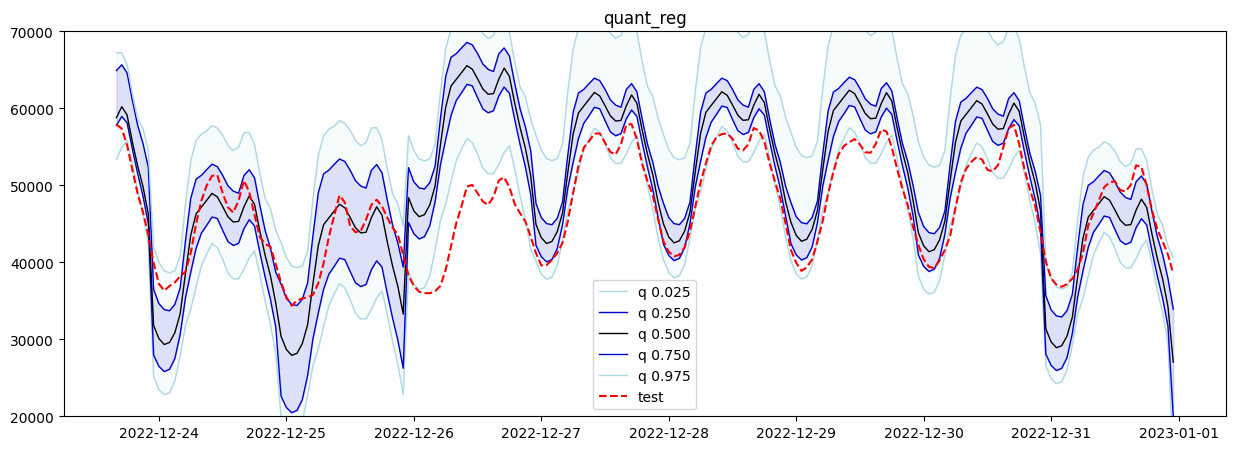

,MSE,MAE,MAPE,pbl=0.025,pbl=0.25,pbl=0.5,pbl=0.75,pbl=0.975
quantile,,,,,,,,
q 0.025,51341819,5139,0.12,709.81,NaN,NaN,NaN,NaN
q 0.250,45540217,5271,0.12,NaN,2581.31,NaN,NaN,NaN
q 0.500,43372037,5252,0.12,NaN,NaN,2626.01,NaN,NaN
q 0.750,66046099,6557,0.14,NaN,NaN,NaN,1789.25,NaN
q 0.975,184595804,12237,0.26,NaN,NaN,NaN,NaN,312.1


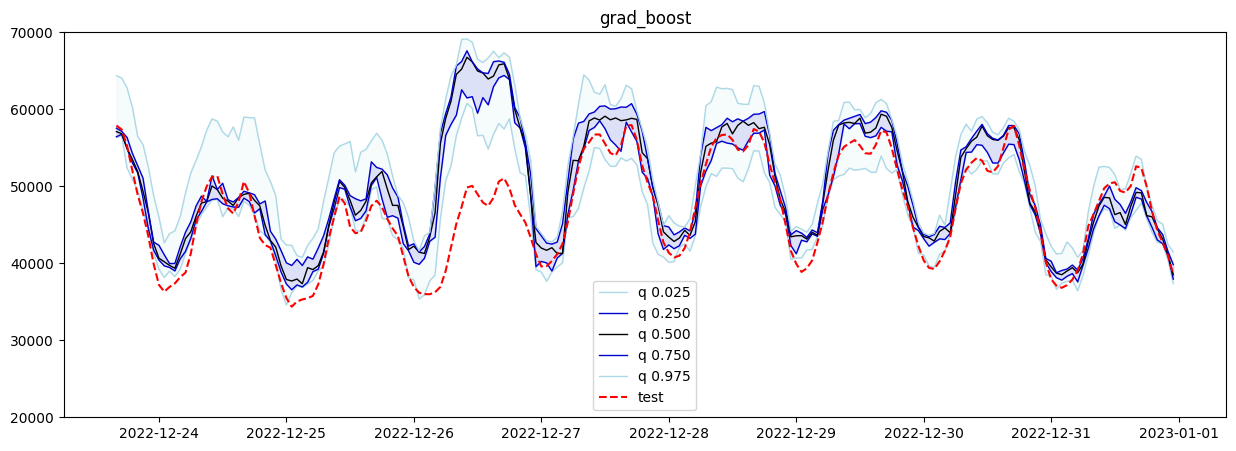

,MSE,MAE,MAPE,pbl=0.025,pbl=0.25,pbl=0.5,pbl=0.75,pbl=0.975
quantile,,,,,,,,
q 0.025,12167613,2523,0.05,1067.64,NaN,NaN,NaN,NaN
q 0.250,19182270,2653,0.06,NaN,1736.24,NaN,NaN,NaN
q 0.500,29185720,3485,0.08,NaN,NaN,1742.66,NaN,NaN
q 0.750,35940140,4236,0.09,NaN,NaN,NaN,1126.72,NaN
q 0.975,63116402,6599,0.14,NaN,NaN,NaN,NaN,165.37


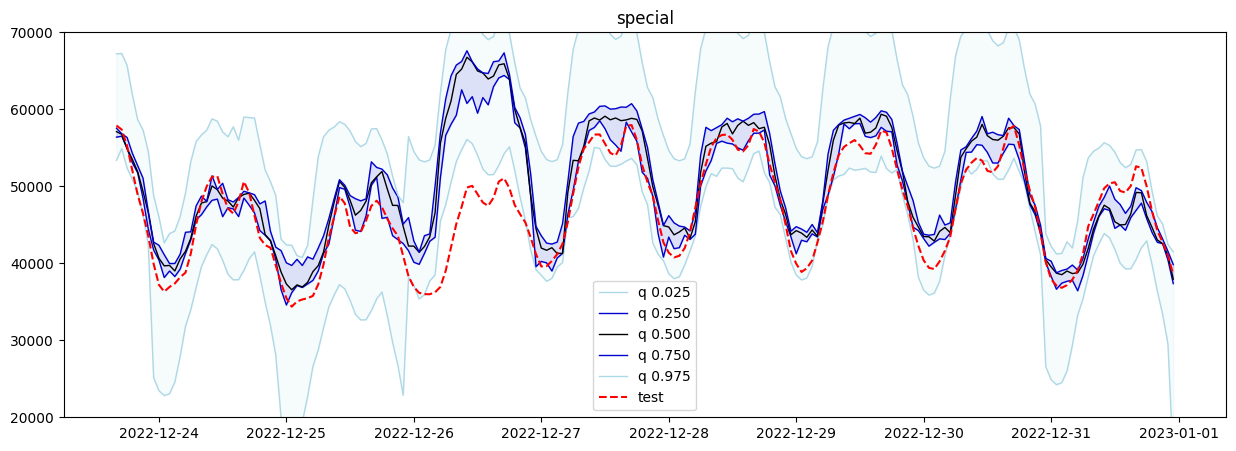

,MSE,MAE,MAPE,pbl=0.025,pbl=0.25,pbl=0.5,pbl=0.75,pbl=0.975
quantile,,,,,,,,
q 0.025,53714021,5667,0.13,588.55,NaN,NaN,NaN,NaN
q 0.250,19251632,2627,0.06,NaN,1659.55,NaN,NaN,NaN
q 0.500,29507214,3543,0.08,NaN,NaN,1771.34,NaN,NaN
q 0.750,38262363,4392,0.10,NaN,NaN,NaN,1171.69,NaN
q 0.975,190685566,12785,0.27,NaN,NaN,NaN,NaN,319.63


In [281]:
df_dict = {'quant_reg': df_quant_reg_pred, 
           'grad_boost': df_grad_boost_pred, 
           # 'ensemble': df_ensemble_pred, 
           'special': df_minmax_ens_pred}

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

# iterate over dict
for model, df in df_dict.items(): 

    plt.figure(figsize=(15, 5))
    plt.title(f'{model}')

    model_errors = []

    for quantile in df.columns:

        y_pred = df[quantile]
        quantile_float = float(quantile[2:])

        metrics = {"quantile": quantile}

        metrics["MSE"] = round(mean_squared_error(y_test_dummy, y_pred))
        metrics["MAE"] = round(mean_absolute_error(y_test_dummy, y_pred))
        metrics["MAPE"] = mean_absolute_percentage_error(y_test_dummy, y_pred)

        # for alpha in quantiles_arr:
        metrics[f"pbl={quantile_float}"] = mean_pinball_loss(y_test_fturs, y_pred, alpha=quantile_float)

        model_errors.append(metrics)

        # Save predicted values based on quantile
        if '0.025' in quantile:
            y_pred_025 = y_pred
            col = 'lightblue'
        elif '0.25' in quantile:
            y_pred_25 = y_pred
            col = 'mediumblue'
        elif '0.5' in quantile:
            y_pred_50 = y_pred
            col = 'black'
        elif '0.75' in quantile:
            y_pred_75 = y_pred
            col = 'mediumblue'
        elif '0.975' in quantile:
            y_pred_975 = y_pred
            col = 'lightblue'
        
        # Plot the prediction line
        plt.plot(y_test_dummy.index, y_pred, label=f'{quantile}', lw=1, alpha=1, color=col)

    plt.fill_between(y_test_dummy.index, y_pred_025, y_pred_975, color='lightblue', alpha=0.1)
    plt.fill_between(y_test_dummy.index, y_pred_25, y_pred_75, color='mediumblue', alpha=0.1)

    plt.plot(y_test_dummy.index, y_test_dummy, 'r--', label='test')
    
    # shift index back by 1 year
    # last_yr_idx = y_test_dummy.index - pd.DateOffset(years=1)
    # plt.plot(y_test_dummy.index, y_train_dummy.loc[last_yr_idx], label='last year')

    plt.ylim(20_000, 70_000)
    plt.legend()
    plt.show()

    df_results = pd.DataFrame(model_errors).set_index("quantile")

    # add last row in dataframe which is the sum of all above values
    # df_results.loc["total"] = df_results.sum()

    # highlight min in column
    # print MSE in scientific notation
    # display(df_results.style.highlight_min(axis=0))

    display(round(df_results, 2))
